In [49]:
import os
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
def read_tf_df(filename, libn):
    colnames = ["chrom", "start", "end", "chrom_coord", f"{libn}_act", "strand", f"{libn}_log2FoldChange_act", f"gene_name", f"{libn}_log2FoldChange_exp", f"{libn}_padj_act", f"{libn}_padj_exp", "CC_peak", f"{libn}_peak"]
    return pd.read_csv(filename, sep="\t", header=None, names=colnames)

In [9]:
def get_filename(tf, filetype):
    proj_dir= "/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks"
    filename = os.path.join(proj_dir, tf, f"{filetype}.bed")
    return filename

In [19]:
def set_add(a,b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersect_counts(include_sets, exclude_sets):
    intersect_set = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_set] + exclude_sets
        intersect_set = reduce(set_subtract, exclude_sets)
    return len(intersect_set)

def get_upset_df(lib_names, lib_pairs):
    lib_set_dict = {ln: lp for ln,lp in zip(lib_names, lib_pairs)}
    lib_boolean_dict = {ln:[] for ln in lib_names}
    counts = []
    for i in range(1, len(lib_names) + 1):
        all_combos = list(combinations(lib_names, i))
        for combos in all_combos:
            include_combos = combos
            exclude_combos = [ln for ln in lib_names if ln not in include_combos]
            include_sets = [lib_set_dict[c] for c in include_combos]
            exclude_sets = [lib_set_dict[c] for c in exclude_combos]
            counts.append(get_intersect_counts(include_sets, exclude_sets))
            for c in include_combos:
                lib_boolean_dict[c].append(True)
            for c in exclude_combos:
                lib_boolean_dict[c].append(False)
    lib_boolean_dict["counts"] = counts
    df = pd.DataFrame(lib_boolean_dict)
    return df.set_index(lib_names)

In [20]:
lib_names = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2"]

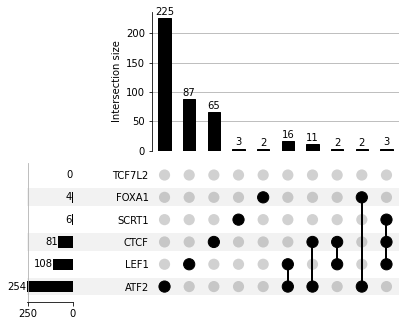

In [47]:
lib_egs = []

for lib_name in lib_names:
    lib_file = get_filename(lib_name, "direct_loss")
    lib_df = read_tf_df(lib_file, lib_name)
    eg_pair_set = set(lib_df.loc[:, ["chrom_coord", "gene_name"]].apply(lambda x: "_".join(x), axis=1).values)
    lib_egs.append(eg_pair_set)

upset_df = get_upset_df(lib_names, lib_egs)
parsed_upset_df = upset_df.loc[upset_df.counts>0]
fig = upsetplot.plot(parsed_upset_df.counts, show_counts=True);

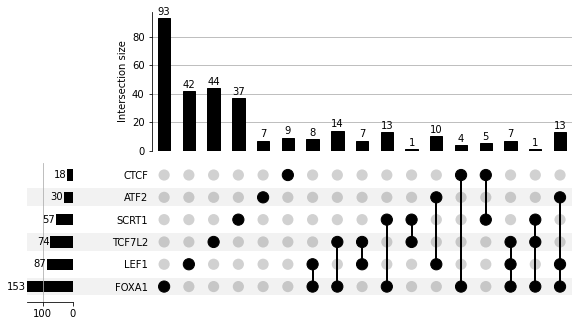

In [48]:
lib_egs = []

for lib_name in lib_names:
    lib_file = get_filename(lib_name, "indirect_gained")
    lib_df = read_tf_df(lib_file, lib_name)
    eg_pair_set = set(lib_df.loc[:, ["chrom_coord", "gene_name"]].apply(lambda x: "_".join(x), axis=1).values)
    lib_egs.append(eg_pair_set)

upset_df = get_upset_df(lib_names, lib_egs)
parsed_upset_df = upset_df.loc[upset_df.counts>0]
fig = upsetplot.plot(parsed_upset_df.counts, show_counts=True);

In [28]:
help(upsetplot.plot)

Help on function plot in module upsetplot.plotting:

plot(data, fig=None, **kwargs)
    Make an UpSet plot of data on fig
    
    Parameters
    ----------
    data : pandas.Series or pandas.DataFrame
        Values for each set to plot.
        Should have multi-index where each level is binary,
        corresponding to set membership.
        If a DataFrame, `sum_over` must be a string or False.
    fig : matplotlib.figure.Figure, optional
        Defaults to a new figure.
    kwargs
        Other arguments for :class:`UpSet`
    
    Returns
    -------
    subplots : dict of matplotlib.axes.Axes
        Keys are 'matrix', 'intersections', 'totals', 'shading'

